In [ ]:
#| default_exp diffusion

# Diffusion Net

In [ ]:
import pickle,gzip,math,os,time,shutil,torch,random,logging
import fastcore.all as fc,matplotlib as mpl,numpy as np,matplotlib.pyplot as plt
from collections.abc import Mapping
from pathlib import Path
from operator import attrgetter,itemgetter
from functools import partial
from copy import copy
from contextlib import contextmanager

from fastcore.foundation import L
from fastprogress import progress_bar
from PIL import Image
import torchvision.transforms.functional as TF,torch.nn.functional as F
import torchvision.transforms as transforms
from torchvision.io import read_image, ImageReadMode
from torch import tensor,nn,optim
from torch.utils.data import DataLoader,default_collate
from torch.nn import init
from torch.optim import lr_scheduler
from torcheval.metrics import MulticlassAccuracy
from datasets import load_dataset,load_dataset_builder

from miniai.datasets import *
from miniai.conv import *
from miniai.learner import *
from miniai.activations import *
from miniai.init import *
from miniai.sgd import *
from miniai.resnet import *
from miniai.augment import *
from miniai.fid import *

In [ ]:
set_seed(1103, False)
mpl.rcParams['image.cmap'] = 'gray'
logging.disable(logging.WARNING)

In [ ]:
#| export
def abar(t):
    return (t * (math.pi / 2)).cos() ** 2

In [ ]:
#| export
def inv_abar(x):
    return x.sqrt().acos() * (2 / math.pi)

In [ ]:
#| export
def add_noise(x):
    device = x.device
    bs = x.shape[0]

    t = torch.rand((bs,), device=device)
    alpha_bar_t = abar(t).reshape((bs,) + (1,) * (len(x.shape) - 1))
    
    original_part = alpha_bar_t.sqrt() * x
    epsilon = torch.randn(x.shape, device=device)
    noise_part = (1 - alpha_bar_t).sqrt() * epsilon

    xt = original_part + noise_part
    return (xt, t.to(device)), epsilon

In [ ]:
#| export
def collate_ddpm(b, fm_x="image"):
    return add_noise(default_collate(b)[fm_x])

In [ ]:
#| export
def dl_ddpm(ds, bs):
    return DataLoader(ds, batch_size=bs, collate_fn=collate_ddpm, num_workers=4)

In [ ]:
fm_x, fm_y = "image", "label"
name = "fashion_mnist"
ds = load_dataset(name)

In [ ]:
@inplace
def transformi(b):
    b["image"] = [TF.pad(TF.to_tensor(i), padding=2, fill=0, padding_mode="constant") * 2 - 1 for i in b["image"]]
dst = ds.with_transform(transformi)

bs = 64
dls = DataLoaders(dl_ddpm(dst["train"], bs), dl_ddpm(dst["test"], bs))
xb, yb = next(iter(dls.train))

## Train

In [ ]:
#| export
def timestamp_embedding(tsteps, emb_dim, max_period=1000):
    mult = 1 / max_period ** torch.linspace(0, 1, emb_dim // 2, device=tsteps.device)
    emb_t = tsteps[:, None] * mult[None]
    emb = torch.cat((torch.sin(emb_t), torch.cos(emb_t)), dim=1)
    return emb

In [ ]:
timestamp_embedding(torch.empty(5), 16).shape

torch.Size([5, 16])

In [ ]:
#| export
def pre_conv(ni, nf, ks=3, stride=1, act=nn.SiLU, norm=None, bias=True):
    layers = []

    if act:
        layers.append(act())
    if norm:
        layers.append(norm(ni))
    layers.append(nn.Conv2d(ni, nf, kernel_size=ks, stride=stride, bias=bias, padding=ks//2))

    return nn.Sequential(*layers)

In [ ]:
pre_conv(1,2)(torch.empty(1,1,2,2)).shape

torch.Size([1, 2, 2, 2])

In [ ]:
#| export
def upsample(nf):
    return nn.Sequential(
        nn.UpsamplingNearest2d(scale_factor=2),
        nn.Conv2d(nf, nf, kernel_size=3, padding=1)
    )

In [ ]:
upsample(1)(torch.empty(1,1,1,1)).shape

torch.Size([1, 1, 2, 2])

In [ ]:
#| export
def heads_to_batch(x, heads):
    bs, c, d = x.shape
    x = x.reshape(bs, c, heads, -1)  # (bs, c, heads, dh)
    x = x.transpose(1, 2)  # (bs, heads, c, dh)
    return x.reshape(bs * heads, c, -1)

def batch_to_heads(x, heads):
    n, c, dh = x.shape
    x = x.reshape(-1, heads, c, dh)  # (bs, heads, c, dh)
    x = x.transpose(1, 2)  # (bs, c, heads, dh)
    bs = n // heads
    return x.reshape(bs, c, heads * dh)

class SelfAttention(nn.Module):
    def __init__(self, n_dim, attn_channels):
        super().__init__()

        self.nheads = nheads = n_dim // attn_channels
        self.scale = 1 / math.sqrt(n_dim / nheads)
        self.qkv = nn.Linear(n_dim, 3 * n_dim)
        self.norm = nn.LayerNorm(n_dim)
        self.lin = nn.Linear(n_dim, n_dim)
        
    def forward(self, x):
        x = x.transpose(1, 2)
        init_x = x
        x = self.qkv(x)
        x = heads_to_batch(x, self.nheads)
        n_dim = x.shape[-1] // 3
        q, k, v = x[..., :n_dim], x[..., n_dim: 2 * n_dim], x[..., 2 * n_dim: 3 * n_dim]
        x = (q @ k.transpose(1, 2) * self.scale).softmax(dim=-1) @ v
        x = batch_to_heads(x, self.nheads)
        x = self.lin(x)
        return self.norm(init_x + x).transpose(1, 2)

In [ ]:
SelfAttention(8, 4)(torch.empty(1,8,4)).shape

torch.Size([1, 8, 4])

In [ ]:
#| export

class SelfAttention2D(SelfAttention):
    def forward(self, x):
        bs, c, h, w = x.shape
        return super().forward(x.reshape(bs, c, -1)).reshape(bs, c, h, w)

In [ ]:
SelfAttention2D(8, 4)(torch.empty(1,8,4,4)).shape

torch.Size([1, 8, 4, 4])

In [ ]:
#| export
def lin(ni, nf, act=nn.SiLU, norm=None, bias=True):
    layers = []

    if act:
        layers.append(act())
    if norm:
        layers.append(norm(ni))
    layers.append(nn.Linear(ni, nf, bias=bias))
    return nn.Sequential(*layers)

In [ ]:
#| export

class EmbResBlock(nn.Module):
    def __init__(self, n_emb, ni, nf=None, ks=3, act=nn.SiLU, norm=nn.BatchNorm2d, attn_channels=0):
        super().__init__()
        if nf is None:
            nf = ni

        self.emb_layer = lin(n_emb, nf * 2)
        self.nf = nf
        self.convs = nn.Sequential(
            pre_conv(ni, nf, ks=ks, act=act, norm=norm),
            pre_conv(nf, nf, ks=ks, act=act, norm=norm)
        )
        if ni == nf:
            self.id_conv = fc.noop
        else:
            self.id_conv = pre_conv(ni, nf, ks=1, act=None)

        self.attention = fc.noop
        if attn_channels:
            self.attention = SelfAttention2D(nf, attn_channels)

    def forward(self, x):
        x, t = x
        init_x = x
        x = self.convs[0](x)
        emb = self.emb_layer(t)[..., None, None]
        x = x * (1 + emb[:, :self.nf])  + emb[:, self.nf:]
        x = self.convs[1](x)
        x = x + self.id_conv(init_x)
        return x + self.attention(x)

In [ ]:
EmbResBlock(8, 2, 3)((torch.empty(1, 2, 4, 4), torch.empty(1, 8))).shape

torch.Size([1, 3, 4, 4])

In [ ]:
#| export

class SaveModule:
    def forward(self, x, *args, **kwargs):
        self.output = super().forward(x, *args, **kwargs)
        return self.output

class SaveEmbResBlock(SaveModule, EmbResBlock):
    ...

class SaveConv(SaveModule, nn.Conv2d):
    ...

In [ ]:
_ = SaveEmbResBlock(8, 2, 3)
print(_((torch.empty(1, 2, 4, 4), torch.empty(1, 8))).shape)
print(_.output.shape)
del _

torch.Size([1, 3, 4, 4])
torch.Size([1, 3, 4, 4])


In [ ]:
#| export

class DownBlock(nn.Module):
    def __init__(self, n_emb, ni, nf, add_down=True, num_layers=1, attn_channels=0):
        super().__init__()

        layers = [SaveEmbResBlock(n_emb, ni, nf)]
        for i in range(1, num_layers):
            layers.append(SaveEmbResBlock(n_emb, nf, nf, attn_channels=attn_channels))
        self.layers = nn.Sequential(*layers)

        self.add_down = add_down
        if add_down:
            self.down = SaveConv(nf, nf, kernel_size=3, stride=2, padding=1)

    def forward(self, x):
        x, t = x
        self.output = []
        for l in self.layers:
            x = l((x, t))
            self.output.append(l.output)
        if self.add_down:
            x = self.down(x)
            self.output.append(self.down.output)
        return x

In [ ]:
_ = DownBlock(5, 4, 8, num_layers=2, attn_channels=1)
print(_((torch.empty(1,4,6,6), torch.empty(1,5))).shape)
for o in _.output:
    print(o.shape)
del _

torch.Size([1, 8, 3, 3])
torch.Size([1, 8, 6, 6])
torch.Size([1, 8, 6, 6])
torch.Size([1, 8, 3, 3])


In [ ]:
#| export

class UpBlock(nn.Module):
    def __init__(self, n_emb, ni, prev_nf, nf, add_up=True, num_layers=2, attn_channels=0):
        super().__init__()
        blocks = [EmbResBlock(n_emb, prev_nf + nf, nf, attn_channels=attn_channels)]
        for i in range(1, num_layers - 1):
            blocks.append(EmbResBlock(n_emb, nf + nf, nf, attn_channels=attn_channels))
        blocks.append(EmbResBlock(n_emb, nf + ni, nf, attn_channels=attn_channels))
        self.blocks = nn.Sequential(*blocks)
        
        if add_up:
            self.up = upsample(nf)
        else:
            self.up = fc.noop

    def forward(self, x, ups):
        x, t = x
        for i, block in enumerate(self.blocks):
            x = block((torch.cat((x, ups[i]), dim=1), t))
        return self.up(x)

In [ ]:
UpBlock(8,3,2,4, True, 3, attn_channels=4).eval()(
    (torch.empty(1,4,1,1), torch.empty(1, 8)),
    [torch.empty(1,2,1,1), torch.empty(1,4,1,1), torch.empty(1,3,1,1)]
).shape

torch.Size([1, 4, 2, 2])

In [ ]:
#| export

class EmbUNetModel(nn.Module):
    def __init__(self, in_channels=3, out_channels=3, nfs=(224, 448, 672, 896), num_layers=1, attn_channels=8, attn_start=1):
        super().__init__()

        self.n_emb_t = n_emb_t = nfs[0]
        self.n_emb = n_emb = nfs[0]

        self.pre_down = nn.Conv2d(in_channels, nfs[0], kernel_size=3, padding=1)
        self.pre_down_emb = nn.Sequential(
            lin(n_emb_t, n_emb, norm=nn.BatchNorm1d),
            lin(n_emb, n_emb, norm=nn.BatchNorm1d)
        )
        self.down = nn.Sequential(*[
            DownBlock(
                n_emb,
                nfs[max(0, i - 1)], nfs[i], 
                add_down=(i != len(nfs) - 1), num_layers=num_layers,
                attn_channels=(attn_channels if i > attn_start else 0)
            ) for i in range(len(nfs))
        ])

        self.pre_up = EmbResBlock(n_emb, nfs[-1])
        self.up = nn.Sequential(*[
            UpBlock(
                n_emb,
                nfs[max(0, i - 1)], nfs[min(len(nfs) - 1, i + 1)], nfs[i],
                add_up=(i != 0), num_layers=num_layers+1,
                attn_channels=attn_channels
            ) for i in range(len(nfs) - 1, -1, -1)
        ])
        self.post_up = pre_conv(nfs[0], out_channels, norm=nn.BatchNorm2d)

    def forward(self, x):
        x, t = x
        emb_t = timestamp_embedding(t, self.n_emb_t, 1000)
        
        x = self.pre_down(x)
        emb = self.pre_down_emb(emb_t)
        down_act = []
        new = [x]

        for b in self.down:
            x = b((x, emb))
        for b in self.down:
            new = [new[0], *b.output[:-1]]
            down_act.append(new)
            new = [b.output[-1]]
        down_act[-1].append(new[0])

        x = self.pre_up((x, emb))
        for i, b in enumerate(self.up):
            x = b((x, emb), down_act[-i - 1][::-1])
        x = self.post_up(x)

        return x

In [ ]:
xb[0].shape

torch.Size([64, 1, 32, 32])

In [ ]:
EmbUNetModel(in_channels=1, out_channels=1, nfs=(16,32,32,32), num_layers=2)((xb[0][:8], xb[1][:8])).shape

torch.Size([8, 1, 32, 32])

In [ ]:
init_w = partial(init_weights, leak=0.1)
cbs = [DeviceCB(), ProgressCB(plot=True), MetricsCB()]
opt_func = partial(optim.AdamW, eps=1e-4)

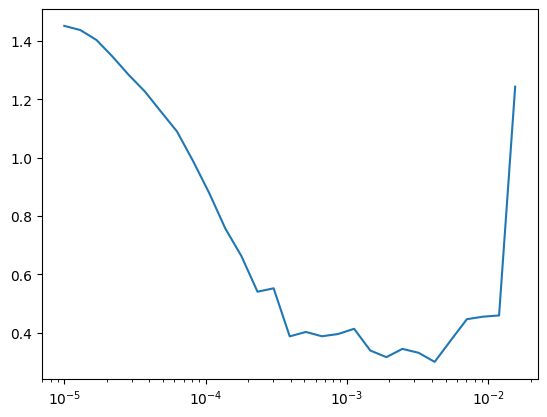

In [ ]:
set_seed(1103, False)
TrainLearner(
    EmbUNetModel(in_channels=1, out_channels=1, nfs=(32, 64, 128, 256), num_layers=2, attn_channels=32),#.apply(init_w),
    dls, F.mse_loss, lr=0.1, cbs=[DeviceCB()], opt_func=opt_func
).lr_find()

loss,epoch,train
0.140,0,train
0.088,0,valid
0.076,1,train
0.069,1,valid
0.067,2,train
0.066,2,valid
0.062,3,train
0.065,3,valid
0.060,4,train
0.061,4,valid


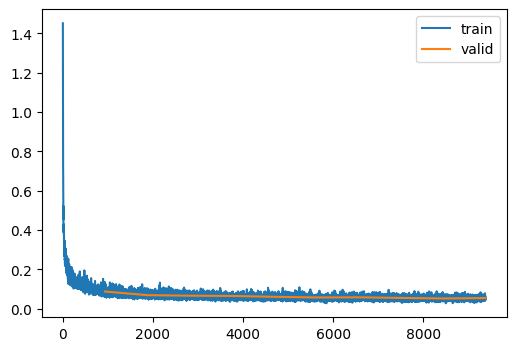

In [ ]:
set_seed(1103, False)
lr = 0.002
epochs = 10
tmax = epochs * len(dls.train)
sched = BatchSchedCB(partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax))
cbs = [DeviceCB(), ProgressCB(True), MetricsCB(), sched]

model = EmbUNetModel(in_channels=1, out_channels=1, nfs=(32, 64, 128, 256), num_layers=2, attn_channels=32)#.apply(init_w)

opt_func = partial(optim.AdamW, eps=1e-4)

learn = TrainLearner(model, dls, F.mse_loss, lr=lr, cbs=cbs, opt_func=opt_func)
learn.fit(epochs)

In [ ]:
model_path = Path("models")
model_path.mkdir(exist_ok=True)
torch.save(learn.model, model_path / "28_diffusion_attn-uncond_10.pkl")

## Sampling

In [ ]:
model_path = Path("models")
model = torch.load(model_path / "28_diffusion_attn-uncond_10.pkl").cuda()

In [ ]:
#| export

def ddim_step(x_t, noise, alpha_bar_t, alpha_bar_t_minus_1, beta_bar_t, beta_bar_t_minus_1, eta, clipv=2):
    # Equation (12)
    predicted_coef = alpha_bar_t_minus_1.sqrt()
    predicted_x0 = ((x_t - beta_bar_t.sqrt() * noise) * (1 / alpha_bar_t.sqrt())).clip(-clipv, clipv)
    sigma_t = (beta_bar_t_minus_1 / beta_bar_t).sqrt() * (1 - alpha_bar_t / alpha_bar_t_minus_1).sqrt() * eta
    if sigma_t.isnan().item():
        sigma_t = 0
    noise_coef = beta_bar_t_minus_1 - sigma_t ** 2
    if noise_coef < 1e-5:
        noise_coef = beta_bar_t_minus_1
    direction_to_x_t = (beta_bar_t_minus_1 - sigma_t ** 2).sqrt() * noise
    random_noise = sigma_t * torch.randn(x_t.shape, device=x_t.device)
    x_t_minus_1 = predicted_coef * predicted_x0 + direction_to_x_t + random_noise
    return x_t_minus_1

In [ ]:
#| export

def sample(f, model, sz, steps, eta=1., return_process=False):
    ts = torch.linspace(0.99, 0, steps)
    device = next(model.parameters()).device
    with torch.no_grad():
        x = torch.randn(sz, device=device)
        bs = x.shape[0]
        if return_process: process = []

        for idx, t in enumerate(progress_bar(ts)):
            t_batch = torch.full((bs,), t, dtype=torch.float, device=device)
            noise_pred = model((x, t_batch))

            alpha_bar_t = abar(t)
            alpha_bar_t_minus_1 = abar(t - 1 / steps) if t >= 1 / steps else tensor(1)
            beta_bar_t = 1 - alpha_bar_t
            beta_bar_t_minus_1 = 1 - alpha_bar_t_minus_1
            x = f(x, noise_pred, alpha_bar_t, alpha_bar_t_minus_1, beta_bar_t, beta_bar_t_minus_1, eta)

            if return_process: process.append(to_cpu(x))
    if return_process: return process
    return to_cpu(x)

In [ ]:
bs2 = 256

In [ ]:
set_seed(1103, False)
samples = sample(ddim_step, model, (bs2, 1, 32, 32), 100)
samples.min(), samples.max()

(tensor(-1.0461), tensor(1.5909))

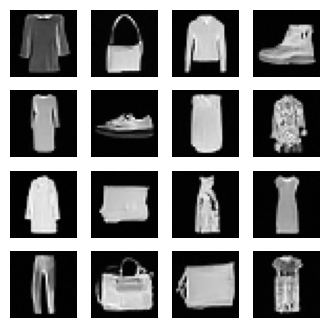

In [ ]:
show_images(samples[:16], imsize=1);

In [ ]:
@inplace
def transformi2(b):
    b["image"] = [TF.pad(TF.to_tensor(i), padding=2, fill=0, padding_mode="constant") * 2 - 1 for i in b["image"]]
dst2 = ds.with_transform(transformi2)

dls2 = DataLoaders.from_dd(dst2, bs2)
xb, yb = next(iter(dls2.train))

fid_model = torch.load('models/14_aug_for_fid.pkl')
del fid_model[8]
del fid_model[7]

image_eval = ImageEval(fid_model, dls2, cbs=[DeviceCB()])
xb.min(), xb.max()

(tensor(-1.), tensor(1.))

In [ ]:
image_eval.fid(samples), image_eval.kid(samples)

(33.993896484375, 0.15245914459228516)

In [ ]:
samples = samples.clip(-1, 1)
image_eval.fid(samples), image_eval.kid(samples)

(33.5345458984375, 0.1479034423828125)

In [ ]:
image_eval.fid(xb), image_eval.kid(xb)

(15.4024658203125, -0.006153106689453125)

## Conditional Model

In [ ]:
def collate_ddpm(b, fm_x="image", fm_y="label"):
    b = default_collate(b)
    (x, t), y = add_noise(b[fm_x])
    l = b[fm_y]
    return (x, t, l), y

In [ ]:
@inplace
def transformi(b):
    b["image"] = [TF.pad(TF.to_tensor(i), padding=2, fill=0, padding_mode="constant") * 2 - 1 for i in b["image"]]
dst = ds.with_transform(transformi)

bs = 64
dls = DataLoaders(dl_ddpm(dst["train"], bs), dl_ddpm(dst["test"], bs))
xb, yb = next(iter(dls.train))

In [ ]:
class CondUNetModel(nn.Module):
    def __init__(self, n_classes, in_channels=3, out_channels=3, nfs=(224, 448, 672, 896), num_layers=1, attn_channels=8, attn_start=1):
        super().__init__()

        self.n_emb_t = n_emb_t = nfs[0]
        self.n_emb = n_emb = nfs[0]

        self.class_emb = nn.Embedding(n_classes, n_emb)

        self.pre_down = nn.Conv2d(in_channels, nfs[0], kernel_size=3, padding=1)
        self.pre_down_emb = nn.Sequential(
            lin(n_emb_t, n_emb, norm=nn.BatchNorm1d),
            lin(n_emb, n_emb, norm=nn.BatchNorm1d)
        )
        self.pre_down_class = lin(n_emb, n_emb)
        self.down = nn.Sequential(*[
            DownBlock(
                n_emb,
                nfs[max(0, i - 1)], nfs[i], 
                add_down=(i != len(nfs) - 1), num_layers=num_layers,
                attn_channels=(attn_channels if i > attn_start else 0)
            ) for i in range(len(nfs))
        ])

        self.pre_up = EmbResBlock(n_emb, nfs[-1])
        self.up = nn.Sequential(*[
            UpBlock(
                n_emb,
                nfs[max(0, i - 1)], nfs[min(len(nfs) - 1, i + 1)], nfs[i],
                add_up=(i != 0), num_layers=num_layers+1,
                attn_channels=attn_channels
            ) for i in range(len(nfs) - 1, -1, -1)
        ])
        self.post_up = pre_conv(nfs[0], out_channels, norm=nn.BatchNorm2d)

    def forward(self, x):
        x, t, l = x
        emb_t = timestamp_embedding(t, self.n_emb_t, 1000)

        emb_class = self.class_emb(l)
        x = self.pre_down(x)
        emb = self.pre_down_emb(emb_t) + self.pre_down_class(emb_class)
        down_act = []
        new = [x]

        for b in self.down:
            x = b((x, emb))
        for b in self.down:
            new = [new[0], *b.output[:-1]]
            down_act.append(new)
            new = [b.output[-1]]
        down_act[-1].append(new[0])

        x = self.pre_up((x, emb))
        for i, b in enumerate(self.up):
            x = b((x, emb), down_act[-i - 1][::-1])
        x = self.post_up(x)

        return x

In [ ]:
CondUNetModel(n_classes=10, in_channels=1, out_channels=1, nfs=(16,32,32,32), num_layers=2)((xb[0][:8], xb[1][:8], xb[2][:8])).shape

torch.Size([8, 1, 32, 32])

loss,epoch,train
0.137,0,train
0.092,0,valid
0.076,1,train
0.073,1,valid
0.066,2,train
0.065,2,valid
0.062,3,train
0.063,3,valid
0.060,4,train
0.060,4,valid


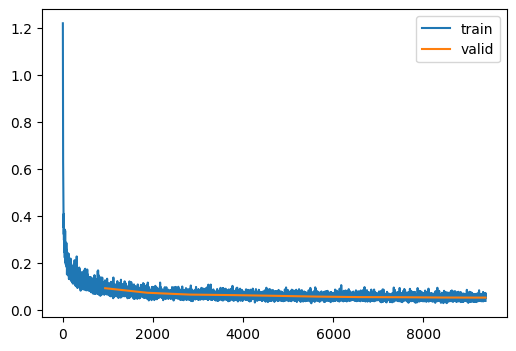

In [ ]:
set_seed(1103, False)
lr = 0.002
epochs = 10
tmax = epochs * len(dls.train)
sched = BatchSchedCB(partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax))
cbs = [DeviceCB(), ProgressCB(True), MetricsCB(), sched]

model = CondUNetModel(n_classes=10, in_channels=1, out_channels=1, nfs=(32, 64, 128, 256), num_layers=2, attn_channels=32)#.apply(init_w)

opt_func = partial(optim.AdamW, eps=1e-4)

learn = TrainLearner(model, dls, F.mse_loss, lr=lr, cbs=cbs, opt_func=opt_func)
learn.fit(epochs)

In [ ]:
model_path = Path("models")
model_path.mkdir(exist_ok=True)
torch.save(learn.model, model_path / "28_diffusion_attn-cond_10.pkl")

In [ ]:
model_path = Path("models")
model = torch.load(model_path / "28_diffusion_attn-cond_10.pkl").cuda()

In [ ]:
#| export
def cond_sample(c, f, model, sz, steps, eta=1., return_process=False):
    ts = torch.linspace(0.99, 0, steps)
    device = next(model.parameters()).device
    with torch.no_grad():
        x = torch.randn(sz, device=device)
        bs = x.shape[0]
        if return_process: process = []

        c_batch = torch.full((bs,), c, dtype=torch.long, device=device)
        for idx, t in enumerate(progress_bar(ts)):
            t_batch = torch.full((bs,), t, dtype=torch.float, device=device)
            noise_pred = model((x, t_batch, c_batch))

            alpha_bar_t = abar(t)
            alpha_bar_t_minus_1 = abar(t - 1 / steps) if t >= 1 / steps else tensor(1)
            beta_bar_t = 1 - alpha_bar_t
            beta_bar_t_minus_1 = 1 - alpha_bar_t_minus_1
            x = f(x, noise_pred, alpha_bar_t, alpha_bar_t_minus_1, beta_bar_t, beta_bar_t_minus_1, eta)

            if return_process: process.append(to_cpu(x))
    if return_process: return process
    return to_cpu(x)

In [ ]:
class2name = dst["train"].features[fm_y].names
class2name

['T - shirt / top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

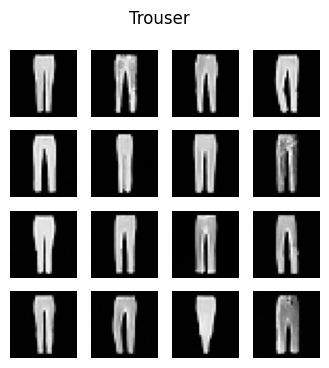

In [ ]:
set_seed(1103, False)
c = 1
samples = cond_sample(c, ddim_step, model, (16, 1, 32, 32), 100)
show_images(samples[:16], imsize=1, suptitle=class2name[c]);

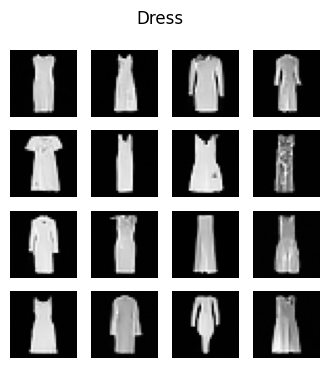

In [ ]:
set_seed(1103, False)
c = 3
samples = cond_sample(c, ddim_step, model, (16, 1, 32, 32), 100)
show_images(samples[:16], imsize=1, suptitle=class2name[c]);

# Export

In [ ]:
import nbdev; nbdev.nbdev_export()